# Compare segmentations produced by passing fixation points as input for SAM with ground truth segmentation masks from PASCAL

- 1) pass 5 points to SAM
- 2) Pass 5 points of model to SAM
- 3) Pass 1 point per viewer to SAM vs. best model point (first one in sorted array)
 
Calculate dice coefficients between obtained segmentation masks and ground truths from Pascal. Statistical test will be conducted to see whether dice coefficients between model and human segmentation masks (and between individual viewers) differ significantly.

- filter images and machine points for whether there exists ground truth for that image and where both model and human are right (were able to detect object).

### 1) Get Data and Filter Images for those where there exists a segmentation groundth truth mask in PASCAL and for images where both model and humans were able to detect the object.

In [1]:
import pandas as pd
import os
import glob
import numpy as np
import json
import cv2
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image
import tensorflow as tf
from scipy import stats
import seaborn as sns

In [2]:
DIR = "/kaggle/input/"
IMG_DIR = os.path.join(DIR, "pascal-images/PascalImages/")
GTS_DIR = os.path.join(DIR, "ground-truth-segmentations/segmentations_per_class/") # dir for ground truth segmentations


def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        # Process keys to strip class name and extension
        return {extract_relevant_file_name(key): value for key, value in data.items()}

def get_file_names_both_right(file_path):
    with open(file_path, 'r') as file:
        return {extract_relevant_file_name(line.strip()) for line in file}

# Function to extract relevant part of the filename
def extract_relevant_file_name(file_path):
    base_name = os.path.basename(file_path)
    relevant_name = base_name.split('.')[0]  # This removes the file extension
    relevant_name = '_'.join(relevant_name.split('_')[1:])
    return relevant_name

def get_segmentation_file_names(directory_path):
    files = os.listdir(directory_path)
    # Process the files, remove the extension, and return a set of relevant names
    return {file.split('.')[0] for file in files if os.path.isfile(os.path.join(directory_path, file))}


def find_img_by_suffix(directory, file_name, extension):
    for file in os.listdir(directory):
        if file.endswith(f"{file_name}{extension}"):
            return os.path.join(directory, file)
    print(f"No file found with suffix: {file_name}")
    return None

# Load data
fixation_data = load_json(os.path.join(DIR,'fix-points/point_dict_fixation.json'))  # Fixation points JSON
machine_data = load_json(os.path.join(DIR,'machine-points/fcn_resnet_results_points.json'))  # Machine points JSON
segmentation_file_names = get_segmentation_file_names(os.path.join(DIR,'ground-truth-segmentations/segmentations_per_class'))  # set of file names in segmentations per class
both_right_files = get_file_names_both_right(os.path.join(DIR, 'filter-both-right/both_right.txt'))  # Set of files in both right

# get filters for files where there is a segmentation ground truth + both model and human can detect object
filter = segmentation_file_names.intersection(both_right_files)
print(f"Number of images to process: {len(filter)}")

Number of images to process: 983


### 2) Run SAM and compare to ground truth

In [3]:
def run_sam_with_points(points):
    """
    Runs SAM on an input of points and returns segmentation mask.

    Args:
    - points: List of tuples representing (x, y) coordinates.

    Returns:
    - mask: Segmentation mask for the input points.
    """
    input_points = np.array(points)
    input_labels = np.ones(len(points))  # Label all points as foreground

    masks, scores, _ = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        multimask_output=False
    )
    return masks[0]

def run_sam_with_points_skip_empty_points(points, ground_truth_mask=None):
    """
    Runs SAM on an input of points and returns segmentation mask.

    Args:
    - points: List of tuples representing (x, y) coordinates.
    - ground_truth_mask: ground truth mask to return an array of booleans in the shape of the ground truth mask so dice coefficient can be computed even if there are no points 

    Returns:
    - mask: Segmentation mask for the input points.
    """
    
    filtered_points = [point for point in points if point]
    
    if len(filtered_points) == 0:
        # Return an empty mask if no points are left after filtering
        print("empty points")
        return np.zeros_like(ground_truth_mask, dtype=bool)
        
    input_points = np.array(filtered_points)
    input_labels = np.ones(len(filtered_points))  # Label all points as foreground

    masks, scores, _ = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        multimask_output=False
    )
    return masks[0]
    

def calculate_dice_coefficient(y_true, y_pred): 
    """
    Compute the Dice coefficient between y_true and y_pred. Modified after https://medium.com/the-research-nest/calculating-the-s%C3%B8rensen-dice-coefficient-a-simplified-guide-3b59a1829a82, retrieved Dec 6, 2024.
    
    Args:
    - y_true: Ground truth mask
    - y_pred: Predicted mask
    
    Returns:
    - dice_coeff: The computed Dice coefficient.
    """
    
    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Explicitly cast to float32
    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = tf.cast(y_pred_f, tf.float32)
    
    # Compute the intersection and the sum of the two masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    
    # Compute Dice coefficient
    dice_coeff = (2. * intersection) / union
    
    return dice_coeff.numpy()

def preprocess_mask(mask, threshold=0):
    """
    Converts a mask to a single channel if it has 3 channels.
    Args:
        mask (numpy.ndarray): Input mask, possibly RGB.
    Returns:
        numpy.ndarray: Single-channel mask.
    """
    if len(mask.shape) == 3:  # Check if the mask has 3 channels
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # Binarize the mask: pixels > threshold become 1, others become 0
    _, binary_mask = cv2.threshold(mask, threshold, 1, cv2.THRESH_BINARY)

    # Convert to boolean (True/False)
    boolean_mask = binary_mask.astype(bool)
    
    return boolean_mask

In [4]:
# Load the SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"  # Update this if you have a different model checkpoint path
model_type = "vit_h"  # Specify the SAM model type

# Download the checkpoint file if it's not available
if not os.path.exists(sam_checkpoint):
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# Initialize SAM model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-12-07 08:12:16--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.176.115, 18.238.176.19, 18.238.176.126, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: 'sam_vit_h_4b8939.pth'

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   210MB/s    in 12s     

2024-12-07 08:12:28 (204 MB/s) - 'sam_vit_h_4b8939.pth' saved [2564550879/2564550879]

cuda


/opt/conda/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


(500, 346, 3)
(500, 346)
(500, 346)
(500, 346)
Dice coefficient for human fixation points: 0.8898103833198547
Dice coefficient for machine generated points: 0.9460330009460449
Dice coefficient for human and machine: 0.943004846572876


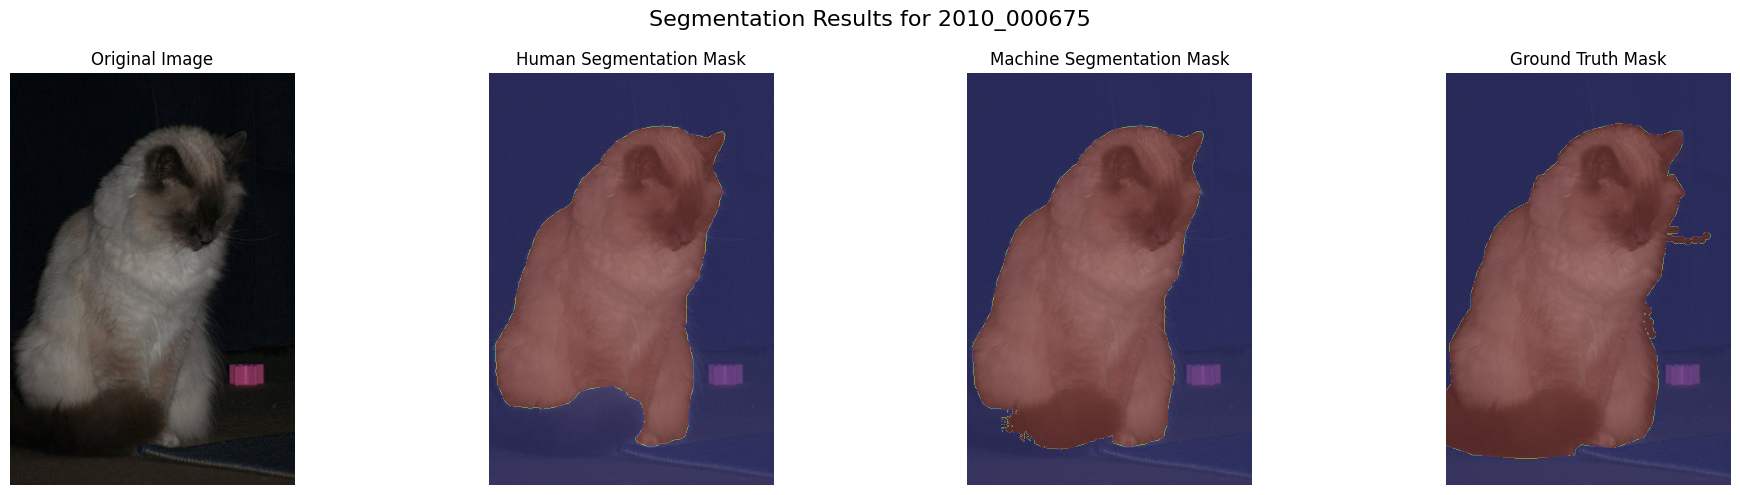

In [7]:
# example for one test

file_name = '2010_000675'
ground_truth_mask_file_path = cv2.imread(find_img_by_suffix(GTS_DIR, file_name, ".png"))
ground_truth_mask = preprocess_mask(ground_truth_mask_file_path)
image_path = find_img_by_suffix(IMG_DIR, file_name, ".jpg")
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

# Set the image in the predictor
predictor.set_image(image)
human_seg_mask = run_sam_with_points(fixation_data[file_name][0]) # get points of all viewers
machine_seg_mask = run_sam_with_points(machine_data[file_name]['points'])
print(machine_seg_mask.shape)
print(human_seg_mask.shape)
print(ground_truth_mask.shape)

dice_coef_human = calculate_dice_coefficient(ground_truth_mask, human_seg_mask)
print(f"Dice coefficient for human fixation points: {dice_coef_human}")

dice_coef_machine = calculate_dice_coefficient(ground_truth_mask, machine_seg_mask)
print(f"Dice coefficient for machine generated points: {dice_coef_machine}")

dice_coef_human_machine = calculate_dice_coefficient(machine_seg_mask, human_seg_mask)
print(f"Dice coefficient for human and machine: {dice_coef_human_machine}")

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")
    
axes[1].imshow(human_seg_mask, cmap='jet', alpha=0.7)
axes[1].imshow(image, alpha=0.5)  # Overlay on original image
axes[1].set_title("Human Segmentation Mask")
axes[1].axis("off")
    
axes[2].imshow(machine_seg_mask, cmap='jet', alpha=0.7)
axes[2].imshow(image, alpha=0.5)  # Overlay on original image
axes[2].set_title("Machine Segmentation Mask")
axes[2].axis("off")
    
axes[3].imshow(ground_truth_mask, cmap='jet', alpha=0.7)
axes[3].imshow(image, alpha=0.5)  # Overlay on original image
axes[3].set_title("Ground Truth Mask")
axes[3].axis("off")
    
fig.suptitle(f"Segmentation Results for {file_name}", fontsize=16)
plt.tight_layout()
plt.show()

### 3) Compute dice coefficient for all filtered images


In [19]:
def compute_dice_coefficients_for_images(file_names, IMG_DIR, GTS_DIR, fixation_data, machine_data):
    """
    Computes Dice coefficients for a list of images compared to human and machine segmentation masks.

    Args:
        file_names (list): List of image file names (without extension).
        IMG_DIR (str): Directory where original images are stored.
        GTS_DIR (str): Directory where ground truth masks are stored.
        fixation_data (dict): Dictionary with fixation points data.
        machine_data (dict): Dictionary with machine points data.

    Returns:
        pd.DataFrame: DataFrame containing the Dice coefficients.
    """
    results = []

    for file_name in tqdm(file_names, desc="Processing images", unit="image"):
        image_path = find_img_by_suffix(IMG_DIR, file_name, ".jpg")
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load and preprocess ground truth mask
        ground_truth_mask_file_path = find_img_by_suffix(GTS_DIR, file_name, ".png")
        ground_truth_mask = cv2.imread(ground_truth_mask_file_path)
        ground_truth_mask = preprocess_mask(ground_truth_mask)

        predictor.set_image(image)

        # Get human and machine segmentation masks
        human_seg_mask = run_sam_with_points_skip_empty_points(fixation_data[file_name][0], ground_truth_mask)  # get human mask
        machine_seg_mask = run_sam_with_points_skip_empty_points(machine_data[file_name]['points'], ground_truth_mask)  # get machine mask
        
        # Compute Dice coefficients
        dice_human = calculate_dice_coefficient(ground_truth_mask, human_seg_mask)
        dice_machine = calculate_dice_coefficient(ground_truth_mask, machine_seg_mask)
  
        results.append({
            "image_file_name": file_name,
            "dice_coefficient_human": dice_human,
            "dice_coefficient_machine": dice_machine
        })

    df = pd.DataFrame(results)
    df.to_csv("/kaggle/working/dice_coefficients.csv", index=False)
    
    return df

df_dice = compute_dice_coefficients_for_images(filter, IMG_DIR, GTS_DIR, fixation_data, machine_data)

print(df_dice)

Processing images:   0%|          | 4/983 [00:09<39:37,  2.43s/image]

empty points


Processing images:  16%|█▌        | 157/983 [06:37<34:32,  2.51s/image]

empty points


Processing images:  25%|██▍       | 244/983 [10:16<31:42,  2.57s/image]

empty points


Processing images:  27%|██▋       | 266/983 [11:12<30:23,  2.54s/image]

empty points


Processing images:  27%|██▋       | 269/983 [11:20<30:15,  2.54s/image]

empty points


Processing images:  33%|███▎      | 326/983 [13:44<27:52,  2.55s/image]

empty points


Processing images:  42%|████▏     | 409/983 [17:14<24:00,  2.51s/image]

empty points


Processing images:  76%|███████▌  | 749/983 [31:32<09:46,  2.51s/image]

empty points


Processing images:  83%|████████▎ | 814/983 [34:16<07:06,  2.52s/image]

empty points


Processing images: 100%|██████████| 983/983 [41:24<00:00,  2.53s/image]

    image_file_name  dice_coefficient_human  dice_coefficient_machine
0       2009_003734                0.814925                  0.668861
1       2008_002719                0.849075                  0.885922
2       2010_004154                0.588942                  0.456777
3       2008_002492                0.005397                  0.000000
4       2009_001332                0.920421                  0.923481
..              ...                     ...                       ...
978     2008_006254                0.384536                  0.083795
979     2008_003451                0.580987                  0.580625
980     2010_001329                0.254220                  0.755276
981     2008_007012                0.805846                  0.886719
982     2009_001117                0.553079                  0.774315

[983 rows x 3 columns]


## Two important considerations: 
If len(points) > 5 ([[348, 153], [325, 175], [], [190, 236], [270, 162]]) we chose to only pass the available points to SAM (see function above run_sam_with_points_skip_empty_points()). 
But how to deal with an image if the points are completely empty? Should we not compare both human and machine segmentation for this image? Right now, the function above returns an empty mask (boolean False in the shape of the ground truth so the dice coefficient can be computed). But actually, this is not very clean since we get a dice coefficient even though the machine or the human was not able to provide points, so it should be 0 (and not some value > 0). On the other hand, it could be a valid approach, since there is nothing detected as True (part of object or foreground) so returning a boolean array with only False could be a way of not punishing the model/viewer performances too much.

###  Statistical Analysis whether dice coefficients of machine and human segmentations with ground truth segmentations differ significantly. 

1) describe() both columns
2) If the data is normally distributed, a paired t-test, otherwise, a wilcoxon signed rank test is performed. 

Shapiro-Wilk test p-value: 6.542493267024503e-21
The differences between human and machine Dice coefficients are not normally distributed.

Wilcoxon signed-rank test result:
Statistic: 176701.0
P-value: 2.603293884493725e-13
There is a significant difference between human and machine Dice coefficients (using Wilcoxon test).


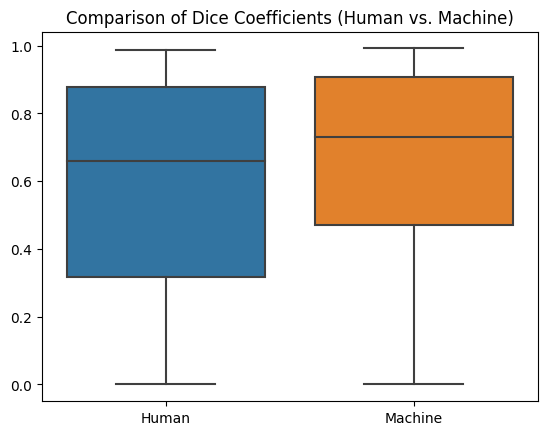

In [23]:
human_dice = df_dice["dice_coefficient_human"]
machine_dice = df_dice["dice_coefficient_machine"]

# Check for normality using the Shapiro-Wilk test
diff = human_dice - machine_dice  # Compute the difference between human and machine Dice coefficients

# Perform the Shapiro-Wilk test for normality on the differences
stat, p_value_normality = stats.shapiro(diff)
print(f"Shapiro-Wilk test p-value: {p_value_normality}")

# Choose the statistical test based on normality
alpha = 0.05  # 5% significance level
if p_value_normality > alpha:
    print("The differences between human and machine Dice coefficients are normally distributed.")
    # Proceed with paired t-test
    t_stat, p_value_ttest = stats.ttest_rel(human_dice, machine_dice)
    print(f"\nPaired t-test result:")
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value_ttest}")
    
    if p_value_ttest < alpha:
        print("There is a significant difference between human and machine Dice coefficients (using t-test).")
    else:
        print("There is no significant difference between human and machine Dice coefficients (using t-test).")
else:
    print("The differences between human and machine Dice coefficients are not normally distributed.")
    # Proceed with Wilcoxon signed-rank test
    stat, p_value_wilcoxon = stats.wilcoxon(human_dice, machine_dice)
    print(f"\nWilcoxon signed-rank test result:")
    #print(f"Statistic: {stat}")
    print(f"P-value: {p_value_wilcoxon}")
    
    if p_value_wilcoxon < alpha:
        print("There is a significant difference between human and machine Dice coefficients (using Wilcoxon test).")
    else:
        print("There is no significant difference between human and machine Dice coefficients (using Wilcoxon test).")

# Step 4: Visualize the Dice coefficients distributions using a boxplot
sns.boxplot(data=[human_dice, machine_dice])
plt.xticks([0, 1], ['Human', 'Machine'])
plt.title('Comparison of Dice Coefficients (Human vs. Machine)')
plt.showÍ

In [24]:
human_dice.describe()

count    983.000000
mean       0.583076
std        0.318181
min        0.002155
25%        0.318639
50%        0.659142
75%        0.877741
max        0.988463
Name: dice_coefficient_human, dtype: float64

In [25]:
machine_dice.describe()

count    983.000000
mean       0.666394
std        0.263576
min        0.000000
25%        0.472253
50%        0.729244
75%        0.906324
max        0.991872
Name: dice_coefficient_machine, dtype: float64

### Calculate dice coefficient for every viewer separately
Now, we want to pass only one point (per viewer) to SAM and compare it with giving the model's best point to SAM. We then compute the dice coefficient again.

In [5]:
# Create dictionaries with one fixation point per filename for every viewer
num_viewers = len(fixation_data[next(iter(fixation_data))][0])

viewer1_fix_point = {}
viewer2_fix_point = {}
viewer3_fix_point = {}
viewer4_fix_point = {}
viewer5_fix_point = {}

viewer_dicts = [viewer1_fix_point, viewer2_fix_point, viewer3_fix_point, viewer4_fix_point, viewer5_fix_point]

for filename, data in fixation_data.items():
    coordinates_list = data[0]
    
    for i in range(num_viewers):
        # Add fixation points for each filename to the respective viewer dictionary
        viewer_dicts[i][filename] = [coordinates_list[i]]
        
#print(viewer1_fix_point)

# Modify the machine data to keep only the first point for each filename
machine_data_one_point = {
    filename: {'points': [data['points'][0]]} if 'points' in data and data['points'] else {'points': []}
    for filename, data in machine_data.items()
}

In [6]:
# change function above slightly so we can compute dice coefficient for every viewer

def compute_dice_coefficients_for_images(file_names, IMG_DIR, GTS_DIR, viewer1_fix_point, viewer2_fix_point, viewer3_fix_point, viewer4_fix_point, viewer5_fix_point, machine_data):
    """
    Computes Dice coefficients for a list of images compared to human and machine segmentation masks.

    Args:
        file_names (list): List of image file names (without extension).
        IMG_DIR (str): Directory where original images are stored.
        GTS_DIR (str): Directory where ground truth masks are stored.
        viewer1_fix_point, ..., viewer5_fix_point (dict): Fixation points for each viewer.
        machine_data (dict): Dictionary with machine points data.

    Returns:
        pd.DataFrame: DataFrame containing the Dice coefficients for each viewer and the machine.
    """
    results = []

    for file_name in tqdm(file_names, desc="Processing images", unit="image"):
        image_path = find_img_by_suffix(IMG_DIR, file_name, ".jpg")
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load and preprocess ground truth mask
        ground_truth_mask_file_path = find_img_by_suffix(GTS_DIR, file_name, ".png")
        ground_truth_mask = cv2.imread(ground_truth_mask_file_path)
        ground_truth_mask = preprocess_mask(ground_truth_mask)

        predictor.set_image(image)

        # Process viewer and machine points
        viewers = [viewer1_fix_point, viewer2_fix_point, viewer3_fix_point, viewer4_fix_point, viewer5_fix_point]
        viewer_dice_scores = {}

        for i, viewer in enumerate(viewers, start=1):
            # Get the segmentation mask for the viewer
            viewer_points = viewer[file_name]
            viewer_seg_mask = run_sam_with_points_skip_empty_points(viewer_points, ground_truth_mask)
            
            # Compute the Dice coefficient for the viewer
            viewer_dice = calculate_dice_coefficient(ground_truth_mask, viewer_seg_mask)
            viewer_dice_scores[f"dice_coefficient_viewer_{i}"] = viewer_dice

        # Get the segmentation mask for the machine
        machine_points = machine_data[file_name]['points']
        machine_seg_mask = run_sam_with_points_skip_empty_points(machine_points, ground_truth_mask)
        dice_machine = calculate_dice_coefficient(ground_truth_mask, machine_seg_mask)

        # Append results
        result = {
            "image_file_name": file_name,
            "dice_coefficient_machine": dice_machine
        }
        result.update(viewer_dice_scores)
        results.append(result)

    # Convert results to DataFrame
    df = pd.DataFrame(results)
    df.to_csv("/kaggle/working/dice_coefficients_per_viewer.csv", index=False)

    return df

df_dice_per_viewer = compute_dice_coefficients_for_images(filter, IMG_DIR, GTS_DIR, viewer1_fix_point, viewer2_fix_point, viewer3_fix_point, viewer4_fix_point, viewer5_fix_point , machine_data_one_point)

Processing images:   4%|▍         | 37/983 [01:12<31:53,  2.02s/image] 

empty points


Processing images:   4%|▍         | 39/983 [01:16<32:18,  2.05s/image]

empty points


Processing images:  10%|▉         | 95/983 [03:22<33:24,  2.26s/image]

empty points


Processing images:  13%|█▎        | 124/983 [04:28<32:19,  2.26s/image]

empty points


Processing images:  27%|██▋       | 261/983 [09:38<27:13,  2.26s/image]

empty points


Processing images:  33%|███▎      | 323/983 [11:58<24:52,  2.26s/image]

empty points


Processing images:  35%|███▌      | 345/983 [12:48<24:00,  2.26s/image]

empty points


Processing images:  43%|████▎     | 427/983 [15:53<20:55,  2.26s/image]

empty points


Processing images:  45%|████▌     | 445/983 [16:34<20:16,  2.26s/image]

empty points


Processing images:  48%|████▊     | 474/983 [17:39<19:07,  2.25s/image]

empty points


Processing images:  53%|█████▎    | 520/983 [19:23<17:27,  2.26s/image]

empty points


Processing images:  57%|█████▋    | 561/983 [20:56<15:52,  2.26s/image]

empty points


Processing images:  58%|█████▊    | 572/983 [21:20<15:29,  2.26s/image]

empty points


Processing images:  66%|██████▌   | 650/983 [24:17<12:31,  2.26s/image]

empty points


Processing images:  67%|██████▋   | 657/983 [24:32<12:14,  2.25s/image]

empty points


Processing images:  73%|███████▎  | 719/983 [26:52<09:56,  2.26s/image]

empty points


Processing images:  77%|███████▋  | 752/983 [28:07<08:40,  2.25s/image]

empty points


Processing images:  84%|████████▎ | 821/983 [30:43<06:06,  2.26s/image]

empty points


Processing images:  84%|████████▍ | 824/983 [30:50<05:59,  2.26s/image]

empty points


Processing images:  84%|████████▍ | 829/983 [31:01<05:47,  2.26s/image]

empty points


Processing images:  87%|████████▋ | 858/983 [32:07<04:42,  2.26s/image]

empty points


Processing images:  88%|████████▊ | 864/983 [32:20<04:28,  2.25s/image]

empty points


Processing images:  88%|████████▊ | 865/983 [32:23<04:26,  2.26s/image]

empty points


Processing images:  89%|████████▉ | 879/983 [32:54<03:55,  2.26s/image]

empty points


Processing images:  95%|█████████▌| 934/983 [34:58<01:50,  2.26s/image]

empty points


Processing images:  96%|█████████▌| 941/983 [35:14<01:35,  2.27s/image]

empty points


Processing images:  98%|█████████▊| 966/983 [36:11<00:38,  2.24s/image]

empty points


Processing images: 100%|██████████| 983/983 [36:49<00:00,  2.25s/image]


### Kruskal-Wallis H-test (non parametric test since dice coefficients are not normally distributed) to test whether there is a significant difference in the means of the distributions

Kruskal-Wallis H-statistic: 11.171873792877957
Kruskal-Wallis p-value: 0.024698808040046098
There is a significant difference between the distributions of Dice coefficients among the viewers.


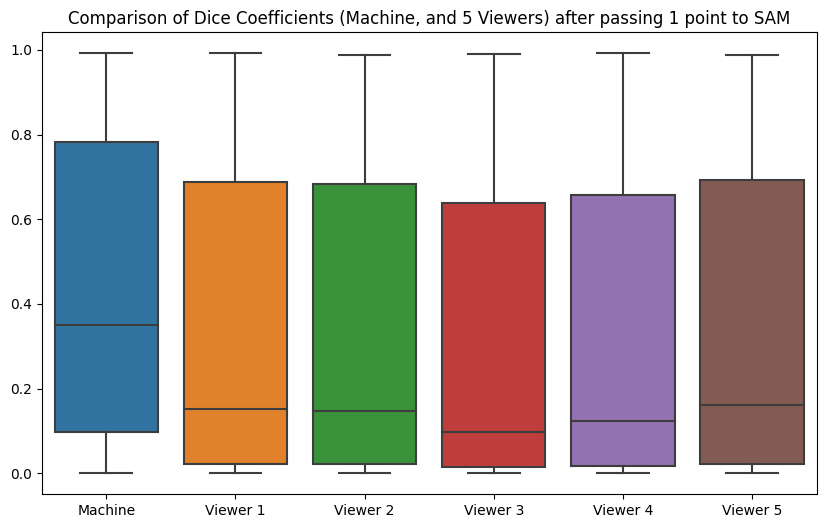

In [12]:
viewer_dice_1 = df_dice_per_viewer['dice_coefficient_viewer_1']
viewer_dice_2 = df_dice_per_viewer['dice_coefficient_viewer_2']
viewer_dice_3 = df_dice_per_viewer['dice_coefficient_viewer_3'] 
viewer_dice_4 = df_dice_per_viewer['dice_coefficient_viewer_4']
viewer_dice_5 = df_dice_per_viewer['dice_coefficient_viewer_5']

machine_dice = df_dice_per_viewer['dice_coefficient_machine']

# Perform Kruskal-Wallis test across the five viewers' Dice coefficients
stat, p_value = stats.kruskal(
    df_dice_per_viewer['dice_coefficient_viewer_1'], 
    df_dice_per_viewer['dice_coefficient_viewer_2'], 
    df_dice_per_viewer['dice_coefficient_viewer_3'], 
    df_dice_per_viewer['dice_coefficient_viewer_4'], 
    df_dice_per_viewer['dice_coefficient_viewer_5']
)


print(f"Kruskal-Wallis H-statistic: {stat}")
print(f"Kruskal-Wallis p-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between the distributions of Dice coefficients among the viewers.")
else:
    print("There is no significant difference between the distributions of Dice coefficients among the viewers.")

data = [machine_dice, viewer_dice_1, viewer_dice_2, viewer_dice_3, viewer_dice_4, viewer_dice_5]
labels = ['Machine', 'Viewer 1', 'Viewer 2', 'Viewer 3', 'Viewer 4', 'Viewer 5']

plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.xticks(range(len(labels)), labels)
plt.title('Comparison of Dice Coefficients (Machine, and 5 Viewers) after passing 1 point to SAM')
plt.show()

In [13]:
viewer_dice_1.describe()

count    983.000000
mean       0.336975
std        0.359728
min        0.000000
25%        0.022681
50%        0.151906
75%        0.686993
max        0.991690
Name: dice_coefficient_viewer_1, dtype: float64

In [14]:
viewer_dice_2.describe()

count    983.000000
mean       0.333331
std        0.359334
min        0.000000
25%        0.021358
50%        0.146104
75%        0.682201
max        0.987080
Name: dice_coefficient_viewer_2, dtype: float64

In [16]:
viewer_dice_3.describe()

count    983.000000
mean       0.310844
std        0.360676
min        0.000000
25%        0.015522
50%        0.098154
75%        0.637522
max        0.991149
Name: dice_coefficient_viewer_3, dtype: float64

In [17]:
viewer_dice_4.describe()

count    983.000000
mean       0.323607
std        0.361157
min        0.000000
25%        0.017866
50%        0.122461
75%        0.657693
max        0.991888
Name: dice_coefficient_viewer_4, dtype: float64

In [18]:
viewer_dice_5.describe()

count    983.000000
mean       0.334152
std        0.359603
min        0.000000
25%        0.020880
50%        0.160245
75%        0.693578
max        0.987005
Name: dice_coefficient_viewer_5, dtype: float64

In [19]:
machine_dice.describe()

count    983.000000
mean       0.429158
std        0.344169
min        0.000000
25%        0.098466
50%        0.349314
75%        0.781688
max        0.992011
Name: dice_coefficient_machine, dtype: float64